# CNN training for fault segmentation and image focusing classification

In this notebook I show the training of the CNN for both fault segmentation as well image focusing classification. I showed how to create training examples for each of these networks in the `FocusedDefocusedTrainingImages.ipynb` and `SyntheticModelBuilding.ipynb` notebooks. In this notebook I load in prepared training datasets (.H5 files) and train the networks. For the fault segmentation network, I test on a inline from a time migrated dataset taken from the F3 block in the North Sea. For the image focusing network, I show the results of the network in the notebook `CNNExampleMutedGathers.ipynb`.

## Import the necessary modules

In [1]:
import os
import numpy as np
# Dataloading
from deeplearn.dataloader import load_alldata, load_labeled_flat_data
# Deep neural networks written in Keras
from deeplearn.kerasnets import unetxwu, vgg3_3d
from deeplearn.keraspredict import segmentfaults
# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
# Plotting
import matplotlib.pyplot as plt
from deeplearn.utils import plotseglabel, plotsegprobs
from utils.plot import plot_cubeiso

/sep/joseph29/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/sep/joseph29/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/sep/joseph29/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/sep/joseph29/anaconda3/envs/tf-gpu/lib/pyt

/sep/joseph29/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/sep/joseph29/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/sep/joseph29/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/sep/joseph29/anaconda

## Training and testing the fault segmentation network

numtr: [########################################] 1100/1100
numva: [........................................] 0/1


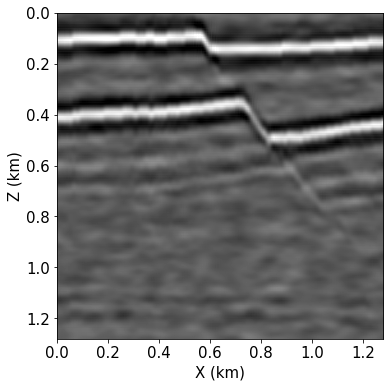

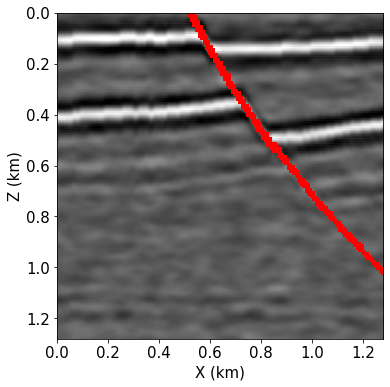

In [2]:
# Get GPU to use
os.environ['CUDA_VISIBLE_DEVICES'] = str(2)

# Training parameters
bsize   = 20
nepochs = 10

# Load in the training data
nptch = 32
allx,ally = load_alldata('/net/fantastic/scr2/joseph29/fltclass.h5',None,nptch) # Load in 32 patches from each image   
                                                                                # Max is 105
nex = allx.shape[0]; nz = allx.shape[1]; nx = allx.shape[2]
dx = 0.01; dz = 0.01
# Plot one training example
fsize = 15; wbox = 6; hbox = 6
iex = 5881
fig = plt.figure(figsize=(wbox,hbox)); ax = fig.gca()
ax.imshow(allx[iex,:,:,0],cmap='gray',interpolation='sinc',extent=[0,nx*dx,nz*dz,0])
ax.set_xlabel('X (km)',fontsize=fsize)
ax.set_ylabel('Z (km)',fontsize=fsize)
ax.tick_params(labelsize=fsize)
plotseglabel(allx[iex,:,:,0],ally[iex,:,:,0],labelsize=fsize,xlabel='X (km)',ylabel='Z (km)',
             xmin=0,xmax=nx*dx,zmin=0,zmax=nz*dz,ticksize=fsize,wbox=wbox,hbox=hbox)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0

Epoch 10/10
28160/28160 [==============================] - 31s 1ms/sample - loss: 0.0012 - acc: 0.9812 - val_loss: 0.0036 - val_acc: 0.9758


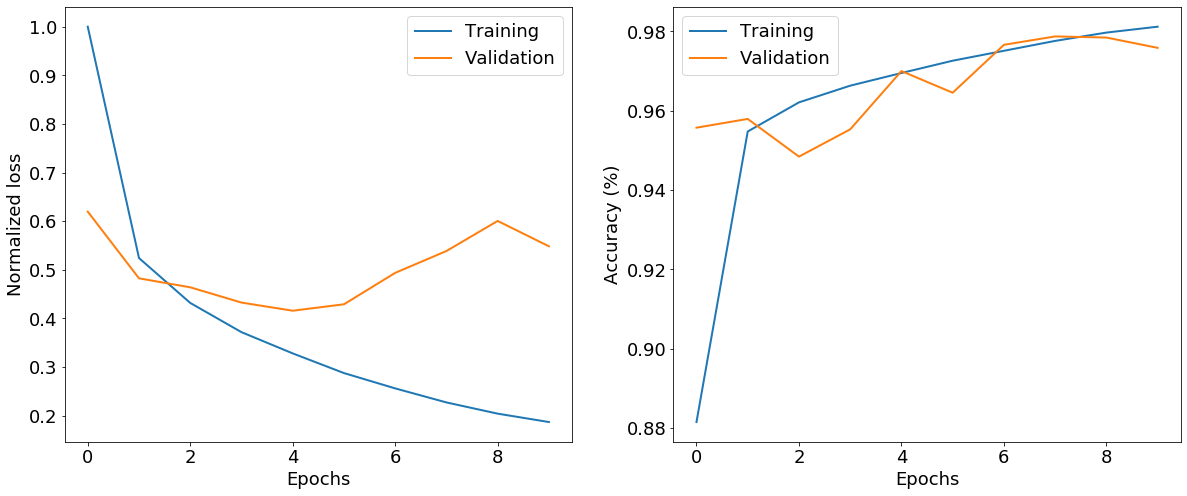

In [3]:
# Get the input model (look in deeplearn.kerasnets for the description of the model)
# It is based on the model described in Wu,2018
# Learning rate is also set in the model (default is 1e-4)
model = unetxwu()

# Set GPUs
tf.compat.v1.GPUOptions(allow_growth=True)

# Train the network
history = model.fit(allx,ally,epochs=nepochs,batch_size=bsize,verbose=1,shuffle=True,validation_split=0.2)

# Get training and validation history
loss = np.asarray(history.history['loss'])
vlss = np.asarray(history.history['val_loss'])
accu = np.asarray(history.history['acc'])
vacu = np.asarray(history.history['val_acc'])

# Plot training and validation loss and accuracy
fsize = 18
fig,ax = plt.subplots(1,2,figsize=(20,8))
ax[0].plot(loss/np.max(loss),label='Training',linewidth=2)
ax[0].plot(vlss/np.max(loss),label='Validation',linewidth=2)
ax[0].legend(fontsize=fsize)
ax[0].set_xlabel('Epochs',fontsize=fsize)
ax[0].set_ylabel('Normalized loss',fontsize=fsize)
ax[0].tick_params(labelsize=fsize)

ax[1].plot(accu,label='Training',linewidth=2)
ax[1].plot(vacu,label='Validation',linewidth=2)
ax[1].legend(fontsize=fsize)
ax[1].set_xlabel('Epochs',fontsize=fsize)
ax[1].set_ylabel('Accuracy (%)',fontsize=fsize)
ax[1].tick_params(labelsize=fsize)

## Load in the F3 Netherlands dataset and predict on a single inline

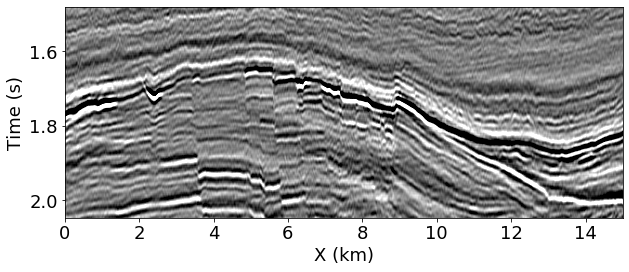

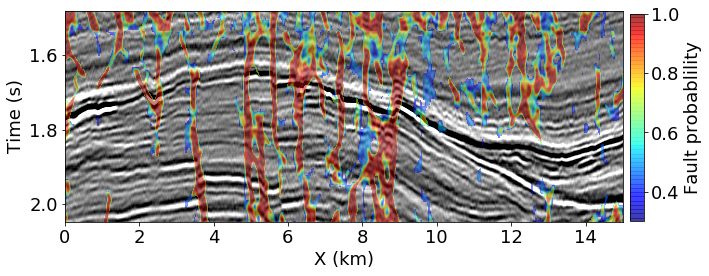

In [4]:
# Read in the inline
f3iline = np.load('../bench/ml/dat/f3iline.npy',allow_pickle=True)[()]

# Segment the faults on this inline
pred = segmentfaults(f3iline,model,nzp=128,nxp=128)

# Plot the prediction
begz = 370; endz = 512 
begx = 0;   endx = 600 
thresh = 0.3
dxf = 0.025; dt = 0.004
fig = plt.figure(figsize=(10,8)); ax = fig.gca()
ax.imshow(f3iline[begz:endz,begx:endx],cmap='gray',interpolation='sinc',vmin=0.2*np.min(f3iline),
          vmax=0.2*np.max(f3iline),extent=[begx*dxf,endx*dxf,endz*dt,begz*dt],aspect=10.0)
ax.set_xlabel('X (km)',fontsize=fsize)
ax.set_ylabel('Time (s)',fontsize=fsize)
ax.tick_params(labelsize=fsize)
plotsegprobs(f3iline[begz:endz,begx:endx],pred[begz:endz,begx:endx],thresh,show=True,
             vmin=0.2*np.min(f3iline),vmax=0.2*np.max(f3iline),aratio=10.0,hbar=0.36,barz=0.32,
             xmax=600*dxf,zmin=begz*dt,zmax=endz*dt,ylabel='Time (s)',xlabel='X (km)',wbox=10,hbox=8)


## Training the fault focusing network

numtr: [########################################] 10080/10080
numva: [........................................] 0/1


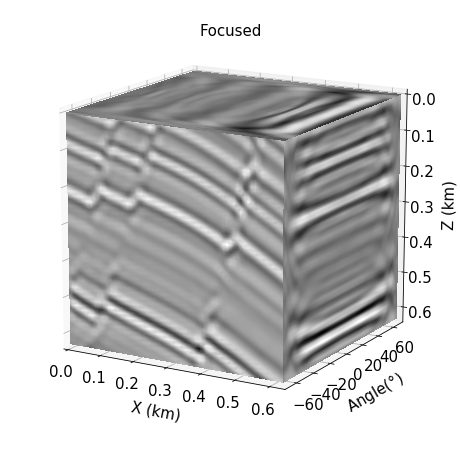

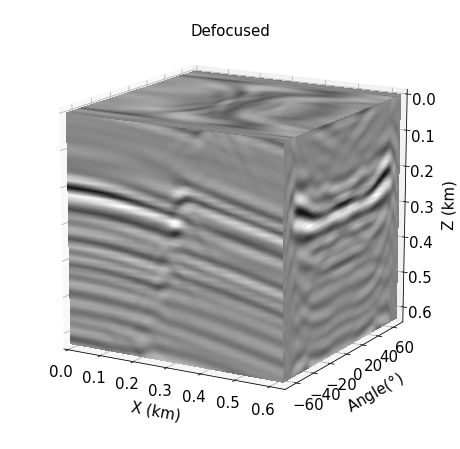

In [5]:
# Load in the training data
focx,focy = load_labeled_flat_data("/scr1/joseph29/angfocus.h5",None)

nfoc = focx.shape[0]
# Plot two training examples
ex1 = 3105; ex2 = 4333
titles = ['Defocused','Focused']
plot_cubeiso(focx[ex1,:,:,:,0],os=[-70.0,0,0],ds=[2.22,0.01,0.01],stack=True,show=True,hbox=8,wbox=8,elev=15,
                 x1label='\nX (km)',x2label='\nAngle'+r'($\degree$)',x3label='\nZ (km)',verb=False,
                 title=titles[int(focy[ex1])])
plot_cubeiso(focx[ex2,:,:,:,0],os=[-70.0,0,0],ds=[2.22,0.01,0.01],stack=True,show=True,hbox=8,wbox=8,elev=15,
                 x1label='\nX (km)',x2label='\nAngle'+r'($\degree$)',x3label='\nZ (km)',verb=False,
                 title=titles[int(focy[ex2])])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 64, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 64, 64, 64, 32)    896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 32, 32, 32, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 32, 32, 32, 64)    55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 16, 16, 16, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 16, 16, 16, 128)   221312    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 8, 8, 8, 128)      0   

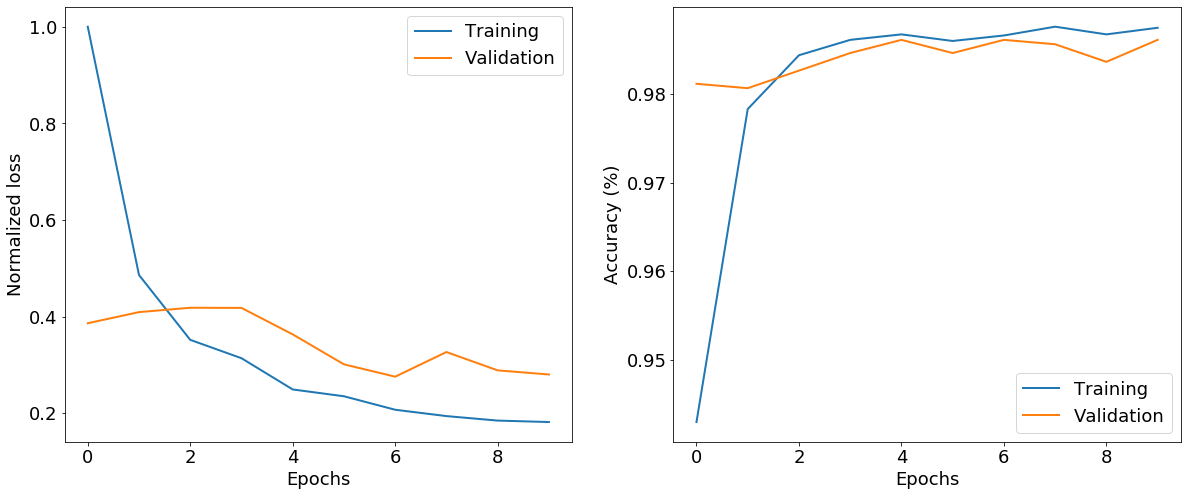

In [6]:
# Get the input model (look in deeplearn.kerasnets for the description of the model)
# Learning rate is also set in the model (default is 1e-4)
model = vgg3_3d()

print(model.summary())

# Set GPUs
tf.compat.v1.GPUOptions(allow_growth=True)

# Train the network
history = model.fit(focx,focy,epochs=nepochs,batch_size=bsize,verbose=1,shuffle=True,validation_split=0.2)

# Get training and validation history
loss = np.asarray(history.history['loss'])
vlss = np.asarray(history.history['val_loss'])
accu = np.asarray(history.history['acc'])
vacu = np.asarray(history.history['val_acc'])

# Plot training and validation loss and accuracy
fsize = 18
fig,ax = plt.subplots(1,2,figsize=(20,8))
ax[0].plot(loss/np.max(loss),label='Training',linewidth=2)
ax[0].plot(vlss/np.max(loss),label='Validation',linewidth=2)
ax[0].legend(fontsize=fsize)
ax[0].set_xlabel('Epochs',fontsize=fsize)
ax[0].set_ylabel('Normalized loss',fontsize=fsize)
ax[0].tick_params(labelsize=fsize)

ax[1].plot(accu,label='Training',linewidth=2)
ax[1].plot(vacu,label='Validation',linewidth=2)
ax[1].legend(fontsize=fsize)
ax[1].set_xlabel('Epochs',fontsize=fsize)
ax[1].set_ylabel('Accuracy (%)',fontsize=fsize)
ax[1].tick_params(labelsize=fsize)